In [32]:
import torch

In [33]:
#默认的张量存储在CPU上
ts1=torch.randn(3,4)
ts1

tensor([[-0.8689, -0.0544,  0.6880,  0.2484],
        [-0.2117,  0.3344,  1.9493,  0.3308],
        [-0.6279,  0.0935, -1.5803,  0.7024]])

In [34]:
#移动到GPU上
ts2=ts1.to('cuda:0')
ts2
#以上操作可以把数据集搬到GPU上，但是神经网络模型也得相应地搬到GPU上

tensor([[-0.8689, -0.0544,  0.6880,  0.2484],
        [-0.2117,  0.3344,  1.9493,  0.3308],
        [-0.6279,  0.0935, -1.5803,  0.7024]], device='cuda:0')

In [35]:
#part1：
#原理概述：
#神经网络的几步：划分数据集（训练集、测试集）-训练网络-测试网络-使用网络
#训练过程即是：经过很多次前向&反向传播的轮回，最终不断调整其内部参数（权重w与偏置b），以拟合任意复杂函数的过程

In [36]:
#part2：DNN实现

In [37]:
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
#展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [39]:
#制作数据集————这里生成10000个样本，设定3个输入特征与3个输出特征
#if（x1+x2+x3）<1 y1=1,else y1=0
#if1<(x1+x2+z3)<2 y2=1,else y2=0
#if（x1+x2+x3）>2 y3=1,else y3=0
#.float()将布尔型张量转化为浮点型张量

In [40]:
#生成数据集
x1=torch.rand(10000,1)
x2=torch.rand(10000,1)
x3=torch.rand(10000,1)         #input feature 1,2,3
x1.shape,x2.shape,x3.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]), torch.Size([10000, 1]))

In [41]:
y1=((x1+x2+x3)<1).float()
y2=((1<(x1+x2+x3))&((x1+x2+x3)<2)).float()
y3=((x1+x2+x3)>2).float()      #output feature 1,2,3
y1.shape,y2.shape,y3.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]), torch.Size([10000, 1]))

In [42]:
Data=torch.cat([x1,x2,x3,y1,y2,y3],axis=1)  #整合数据集
Data=Data.to('cuda:0')     #把数据集搬到GPU上
Data.shape

torch.Size([10000, 6])

In [43]:
#划分训练集和测试集
#这个代码块就可直接拿去用，可调的就只有比例（如这里的0.7）
train_size=int(len(Data)*0.7)
test_size=len(Data)-train_size     #分别划分出训练集和测试集的样本数量
Data=Data[torch.randperm(Data.size(0)) , : ]     #🔺打乱样本的顺序（通用）
train_Data=Data[:train_size,:]  #分割出训练集的样本：从第0行到7k行（size），所有的列
test_Data=Data[train_size:,:]   #分割出测试集的样本：从第7k行到最后一行，所有的列
train_Data.shape,test_Data.shape

(torch.Size([7000, 6]), torch.Size([3000, 6]))

In [44]:
#搭建神经网络：以nn.Module作为父类包含网络各个层的定义，我们自己的神经网络可以直接继承父类的方法与属性
#定义的神经网络子类中，通常包含__init__特殊方法和forward方法，前者用于构造自己的神经网络，后者用于将input进行前向传播
#由于张量可以自动计算梯度，所以不需要出现反向传播方法
class DNN(nn.Module):
    
    def __init__(self):
        "'搭建神经网络各层'"
        super(DNN,self).__init__()
        self.net=nn.Sequential(              #按顺序搭建各层（net就是给网络的取名）
            nn.Linear(3,5),nn.ReLU(),        #第1层：全连接层（数字表 示节点,但注意前后要能相接）
            nn.Linear(5,5),nn.ReLU(),        #第2层：全连接层
            nn.Linear(5,5),nn.ReLU(),        #第3层：全连接层
            nn.Linear(5,3)                   #第4层：全连接层
        )  
        
    def forward(self,x):
        "'前向传播'"
        y=self.net(x)                       #x即input
        return y                            #y即output

In [45]:
model=DNN().to('cuda:0')      #创建子类的实例并搬到GPU上
model                         #查看该实例的各层

DNN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
)

In [46]:
#查看内部参数(即参数)
for name,param in model.named_parameters():
    print(f"参数:{name}\n形状:{param.shape}\n数值{param}\n")

参数:net.0.weight
形状:torch.Size([5, 3])
数值Parameter containing:
tensor([[ 0.1939, -0.4985, -0.0332],
        [ 0.4084, -0.1121, -0.3748],
        [ 0.4743, -0.5720, -0.5761],
        [-0.1037,  0.3206,  0.2584],
        [-0.1003,  0.3491,  0.0999]], device='cuda:0', requires_grad=True)

参数:net.0.bias
形状:torch.Size([5])
数值Parameter containing:
tensor([ 0.5751, -0.1042,  0.3860, -0.5046, -0.4980], device='cuda:0',
       requires_grad=True)

参数:net.2.weight
形状:torch.Size([5, 5])
数值Parameter containing:
tensor([[-0.1621,  0.1921,  0.3017, -0.1652, -0.0421],
        [-0.1891,  0.0282,  0.3078, -0.3840,  0.0191],
        [ 0.0373,  0.2585, -0.4140,  0.1327, -0.3546],
        [-0.2147,  0.0749,  0.3028,  0.3602,  0.1243],
        [ 0.1224, -0.3041,  0.2903, -0.0665, -0.0461]], device='cuda:0',
       requires_grad=True)

参数:net.2.bias
形状:torch.Size([5])
数值Parameter containing:
tensor([ 0.4399,  0.3628, -0.0207,  0.3484, -0.2176], device='cuda:0',
       requires_grad=True)

参数:net.4.weight
形状:

In [47]:
#外部参数（即超参数）

In [48]:
#选择损失函数
loss_fn=nn.MSELoss()

In [49]:
#选择优化算法
learning_rate=0.01    #设置学习率
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)  #这里的SGD只是指梯度下降，并没有使用mini-batch之类的方法

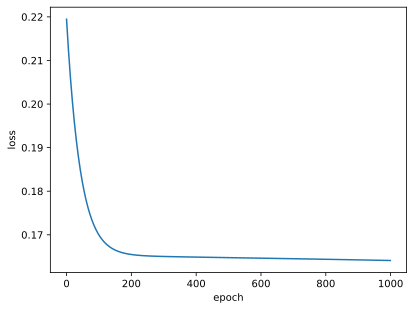

In [50]:
#训练网络
epochs=1000   #轮回1k次
losses=[]     #记录损失函数变化的列表，到时候用于画图

#给训练集划分输入与输出
X=train_Data[:, :3]    #前3列为输入特征
Y=train_Data[:,-3:]    #后3列为输入特征

for epoch in range(epochs):           #PS:以下代码基本固定
    Pred=model(X)                     #对input的X进行一次前向传播（BGD）结果赋给Pred
    loss=loss_fn(Pred,Y)              #计算损失函数：Pred和真实的标签Y之间算一次损失函数
    losses.append(loss.item())        #记录损失函数的变化（损失函数是张量用.item降为python元素append到lossed列表的末尾）
    optimizer.zero_grad()             #清理上一轮滞留的梯度（每一轮梯度不一样）
    loss.backward()                   #一次反向传播
    optimizer.step()                  #优化内部参数

#画图
Fig=plt.figure()
plt.plot(range(epochs),losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [51]:
#测试网络

#给测试集划分input和output
x=test_Data[:, :3]
y=test_Data[:,-3:]         #前3列为input-feature，后3列为output-feature

with torch.no_grad():      #该局部关闭梯度计算功能————让下面几行不计算梯度，节约内存加快运算速度
    Pred=model(x)          #一次前向传播（批量）
    #由于output-feature是独热编码，而预测数据一般是接近0/1的小数，为了能compare要对预测数据进行规整：
    Pred[:,torch.argmax(Pred,axis=1)]=1   #将每行最大的置1，将不是1的数字置0
    Pred[Pred!=1]=0
    correct=torch.sum((Pred==y).all(1))   #True当作1，False当作0，相加刚好的预测correct的样本数
    total=y.size(0)
    print(f'测试集精准度：{100*correct/total}%')

测试集精准度：66.5%


In [ ]:
#保存和导入网络

In [53]:
#保存网络
torch.save(model,'model.pth')    #保存到JupyterNotebook主页面中

In [55]:
#导入网络：新网络=torch.load('文件名.pth')
new_model=torch.load('model.pth')
#这时候new_model就与 model完全一致了，可以拿去跑数据集

In [56]:
#测试新导入的网络
a=test_Data[:, :3]
b=test_Data[:,-3:]         #前3列为input-feature，后3列为output-feature

with torch.no_grad():      #该局部关闭梯度计算功能————让下面几行不计算梯度，节约内存加快运算速度
    Pred=model(a)          #一次前向传播（批量）
    Pred[:,torch.argmax(Pred,axis=1)]=1   #将每行最大的置1，将不是1的数字置0
    Pred[Pred!=1]=0
    correct=torch.sum((Pred==b).all(1))   #True当作1，False当作0，相加刚好的预测correct的样本数
    total=b.size(0)
    print(f'测试集精准度：{100*correct/total}%')

测试集精准度：66.5%
